# Laboratorium 5: Segmentacja polipów — Architektura typu U-Net(Kvasir-SEG)

W tym ćwiczeniu chcemy nauczyć się budowania i trenowania modeli **segmentacji semantycznej** z wykorzystaniem architektury **U-Net** oraz frameworka **PyTorch Lightning** na zbiorze danych medycznych **Kvasir-SEG** (segmentacja polipów jelitowych w obrazach endoskopowych).

**Główne zagadnienia:**
- Implementacja `LightningDataModule`: podział train/val/test, augmentacje spójne dla obrazu i maski.
- Budowa architektury **U-Net 2D** z enkoderem i dekoderem oraz skip connections.
- Funkcje straty dla segmentacji: **BCEWithLogitsLoss** i **Dice Loss**.
- Metryki: **Dice Score** i **IoU** (Intersection over Union) z biblioteki torchmetrics.
- Wykorzystanie **Transfer Learning** ResNet jako encoder w U-Net.

**Dataset:**
Użyjemy **Kvasir-SEG** – zbioru zawierającego obrazy endoskopowe jelita grubego wraz z maskami segmentacji polipów. Dataset ten został stworzony do oceny algorytmów segmentacji w endoskopii i zawiera około 1000 par obraz-maska. Dane zostaną **automatycznie pobrane** w notebooku. Skalujemy je również do rozdzielczości 224x224 aby ograniczyć czas potrzebny na uczenie sieci.

## 0) Instalacja i importy

Jeśli chcemy powtarzalnych wyników możemy ustawić stały SEED.

In [ ]:
!pip -q install pytorch-lightning torchmetrics scikit-image opencv-python pillow --extra-index-url https://download.pytorch.org/whl/cpu

import os, zipfile, urllib.request, random, glob, math
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ssl

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score

import torchvision.models as models
from torchvision.models import ResNet18_Weights


# SEED = 42
SEED = None
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)

if SEED is not None:
    set_seed()

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE, '| Lightning:', pl.__version__)

Device: cuda | Lightning: 2.5.6


## 1) Pobranie i przygotowanie Kvasir-SEG

**Kvasir-SEG** to zbiór danych zawierający obrazy endoskopowe jelita grubego wraz z maskami segmentacji polipów. Poniższy fragment automatycznie pobiera zbiór i sprawdza liczbę pobranych plików.

Należy zwrócić uwagę, że dla zadania segmentacji zarówno obrazy wejściowe jak i groundtruth są obrazami. W przypadku segmentacji binarnej (tło-obiekt) maska ma wartości binarne. Wymusza to delikatnie inne podejście do zarządzania i przetwarzania wstępnego takich danych.

In [ ]:
DATA_ROOT = Path('./data/data_kvasir')
DATA_ROOT.mkdir(parents=True, exist_ok=True)

ZIP_URL = 'https://datasets.simula.no/downloads/kvasir-seg.zip'
ZIP_PATH = DATA_ROOT / 'kvasir.zip'
EXTRACT_DIR = DATA_ROOT / 'Kvasir-SEG'

if not EXTRACT_DIR.exists():
    print('Pobieranie Kvasir-SEG (~150 MB)…')
    ssl._create_default_https_context = ssl._create_unverified_context
    urllib.request.urlretrieve(ZIP_URL, ZIP_PATH)
    print('Rozpakowywanie…')
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(DATA_ROOT)
    print('Gotowe:', EXTRACT_DIR)
else:
    print('Dane już dostępne:', EXTRACT_DIR)

IMG_DIR = EXTRACT_DIR / 'images'
MSK_DIR = EXTRACT_DIR / 'masks'
imgs = sorted(glob.glob(str(IMG_DIR / '*.jpg')))
msks = sorted(glob.glob(str(MSK_DIR / '*.jpg')))
print('Liczba obrazów/masek:', len(imgs), len(msks))
assert len(imgs) == len(msks) and len(imgs) > 0, 'Brak danych lub brak par obraz–maska.'

Dane już dostępne: data/data_kvasir/Kvasir-SEG
Liczba obrazów/masek: 1000 1000


## Zadanie 1 – Dataset i DataModule dla segmentacji

W tym zadaniu zaimplementujesz własny Dataset oraz DataModule dla danych segmentacyjnych. Kluczową różnicą w porównaniu do klasyfikacji jest to, że augmentacje zmieniające pozycję obiektów (wszystkie przekształcenia geometryczne) muszą być stosowane zarówno do obrazu jak i maski – np. jeśli obracamy obraz o 10 stopni, to maskę również musimy obrócić o dokładnie ten sam kąt.

**Dataset dla segmentacji:**
1. Zaimplementuj klasę `KvasirDataset`, która dziedziczy po `Dataset`.
2. W metodzie `__init__` zapamiętaj ścieżki do obrazów (`img_paths`) i masek (`msk_paths`), oraz opcjonalny obiekt transform.
3. W metodzie `__len__` zwróć liczbę obrazów.
4. W metodzie `__getitem__`:
   - Wybierz odpowiednie ścieżki z zapamiętanych list podczas inicjalizacji.
   - Wczytaj obraz i maskę używając funkcji pomocniczej `load_pair`.
   - Jeśli `self.transform` istnieje, zastosuj go do obu (obraz, maska).
   - Zwróć parę (obraz, maska).

**Transform dla segmentacji:**
1. Zaimplementuj klasę `SegmentationTransform`, która będzie stosować te same transformacje do obrazu i maski. W przypadku segmentacji musimy sami ją zaimplementować, aby móć stosować spójną segmentację dla obu obrazów.
2. W metodzie `__init__`:
   - Zapamiętaj `size` (docelowy rozmiar obrazu).
   - Zapamiętaj `augment` (flaga czy stosować augmentacje, domyślnie False).
   - Stwórz obiekt do konwersji PIL do tensor: `transforms.ToTensor()`.
   - Stwórz **dwa** obiekty do resize: `transforms.Resize(size, ...)`. Pierwszy z interpolacją BILINEAR dla obrazu, a drugi z interpolacją NEAREST dla maski. Jest to ważne, gdyż maska jest binarna i nie chcemy rozmywać jej krawędzi.
   - Stwórz obiekt normalizacji: `transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])` – przesunie wartości z [0,1] do [-1,1].
3. W metodzie `__call__(self, img, mask)`:
   - Wykonaj resize dla obrazu i maski (na obrazach PIL).
   - Skonwertuj oba do tensorów (wartości [0, 1]).
   - Zbinaryzuj maskę: `mask = (mask > 0).float()` – chcemy, żeby maska zawiera tylko 0 i 1, ale miała typ zmiennoprzecinkowy.
   - Jeśli `self.augment == True`:
     - Z prawdopodobieństwem 50% wykonaj horizontal flip (dla obu).
     - Z prawdopodobieństwem 50% wykonaj losową rotację o kąt z przedziału [-10, 10] stopni. Zrób to samo dla obu obrazów, ale z różną interpolacją. Wykorzystaj `transforms.functional.rotate` i podaj argument `interpolation`.
   - Znormalizuj obraz (nie maskę) do [-1, 1].
   - Zwróć `(img.float(), mask.float())`.

**DataModule:**
1. Zaimplementuj klasę `KvasirDataModule`, która dziedziczy po `LightningDataModule`.
2. W metodzie `__init__`:
   - Zapamiętaj listy obrazów i masek.
   - Zapamiętaj `batch`, `nw` (num_workers), `train_split`, `val_split`, `img_size`.
   - Stwórz dwa obiekty transformacji: `self.train_transform` (z augment=True) i `self.val_test_transform` (z augment=False) jako obiekty zaimplementowanej wcześniej klasy.
3. W metodzie `setup(self, stage=None)`:
   - Wylosuj indeksy i podziel dane na train/val/test zgodnie z `train_split` i `val_split`. W tym celu stwórz listę indeksów od 0 do liczby próbek, a następnie wymieszaj je za pomocą `np.random.shuffle`. Podziel wynikowy wektor na 3 częsci zgodnie za przekazanym podziałem na część treningową, walidacyjną i testową. Następnie podziel również odpowiednio ścieżki do plików zgodnie z przygotowanymi listami indeksów.
   - Stwórz i zapamiętaj trzy datasety (treningowy, walidacyjny i testowy) z odpowiednimi transformacjami i zawierające próbki zgodnie w wcześniejszym losowaniem.
   - Wyświetl rozmiary zbiorów.
4. Zaimplementuj metody `train_dataloader()`, `val_dataloader()`, `test_dataloader()`:
   - Zwróć DataLoader z odpowiednim datastem.
   - Ustaw `shuffle=True` tylko dla train.
   - Ustaw `pin_memory=True` jeśli CUDA dostępne.

**Poza klasami:**
1. Stwórz instancję `KvasirDataModule` z listami `imgs` i `msks` (były stworzone we wcześniejszej komórce), rozmiarem batcha i liczbą workerów. Wartości te trzeba dobrać na podstawie specyfikacji maszyny na której uruchamiany będzie trening.
2. Wywołaj `dm.setup()`.
3. Pobierz jeden batch z train loadera (`next(iter(dm.train_dataloader()))`) i wyświetl kształty. Powinny pojawić się kształty typu `(16, 3, 384, 384)` dla obrazów i `(16, 1, 384, 384)` dla masek.

In [ ]:
class KvasirDataset(Dataset):
  def __init__(self, img_paths, msk_paths, transform=None):
    self.img_paths = img_paths
    self.msk_paths = msk_paths
    self.transform = transform

  def __len__(self):
    return len(self.img_paths)

  @staticmethod
  def load_pair(img_path, msk_path):
    img = Image.open(img_path).convert('RGB')
    msk = Image.open(msk_path).convert('L')
    return img, msk

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    msk_path = self.msk_paths[idx]

    img, msk = KvasirDataset.load_pair(img_path, msk_path)
    if self.transform:
      img, msk = self.transform(img, msk)

    return img, msk

class SegmentationTransform():
  def __init__(self, size, augment=False):
    self.size = size
    self.augment = augment
    self.to_tensor = transforms.ToTensor()
    self.resize_bl = transforms.Resize((size, size), interpolation=transforms.InterpolationMode.BILINEAR)
    self.resize_n = transforms.Resize((size, size), interpolation=transforms.InterpolationMode.NEAREST)
    self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

  def __call__(self, img, mask):
    img = self.resize_bl(img)
    mask = self.resize_n(mask)
    img = self.to_tensor(img)
    mask = self.to_tensor(mask)

    mask = (mask > 0).float()

    if self.augment:
      if random.random() < 0.5:
        img = transforms.functional.hflip(img)
        mask = transforms.functional.hflip(mask)

      if random.random() < 0.5:
        angle = random.randint(-10, 10)
        img = transforms.functional.rotate(img, angle, interpolation=transforms.InterpolationMode.BILINEAR)
        mask = transforms.functional.rotate(mask, angle, interpolation=transforms.InterpolationMode.NEAREST)

      img = self.normalize(img)

    return img.float(), mask.float()


class KvasirDataModule(LightningDataModule):
  def __init__(self, img_paths, msk_paths, batch=16, nw=4, train_split=0.8, val_split=0.1, img_size=224):
    super().__init__()
    self.img_paths = img_paths
    self.msk_paths = msk_paths
    self.batch = batch
    self.nw = nw  # num_workers
    self.train_split = train_split
    self.val_split = val_split

    self.train_transform = SegmentationTransform(img_size, augment=True)
    self.val_test_transform = SegmentationTransform(img_size, augment=False)

  def setup(self, stage=None):
    indices = np.arange(len(self.img_paths))
    np.random.shuffle(indices)

    train_idx = indices[:int(len(indices)*self.train_split)]
    val_idx = indices[int(len(indices)*self.train_split):int(len(indices)*(self.train_split+self.val_split))]
    test_idx = indices[int(len(indices)*(self.train_split+self.val_split)):]

    train_img_paths = [self.img_paths[i] for i in train_idx]
    train_msk_paths = [self.msk_paths[i] for i in train_idx]
    val_img_paths = [self.img_paths[i] for i in val_idx]
    val_msk_paths = [self.msk_paths[i] for i in val_idx]
    test_img_paths = [self.img_paths[i] for i in test_idx]
    test_msk_paths = [self.msk_paths[i] for i in test_idx]

    self.train_dataset = KvasirDataset(train_img_paths, train_msk_paths, self.train_transform)
    self.val_dataset = KvasirDataset(val_img_paths, val_msk_paths, self.val_test_transform)
    self.test_dataset = KvasirDataset(test_img_paths, test_msk_paths, self.val_test_transform)

    print('Train size:', len(self.train_dataset))
    print('Val size:', len(self.val_dataset))
    print('Test size:', len(self.test_dataset))

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch, shuffle=True, num_workers=self.nw, pin_memory=True if DEVICE == 'cuda' else False)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=self.batch, shuffle=False, num_workers=self.nw, pin_memory=True if DEVICE == 'cuda' else False)

  def test_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=self.batch, shuffle=False, num_workers=self.nw, pin_memory=True if DEVICE == 'cuda' else False)



In [ ]:
BATCH = 16
NUM_WORKERS = 4

dm = KvasirDataModule(imgs, msks, batch=BATCH, nw=NUM_WORKERS, train_split=0.8, val_split=0.1, img_size=384)
dm.setup()

xb, yb = next(iter(dm.train_dataloader()))
print(xb.shape, yb.shape)

Train size: 800
Val size: 100
Test size: 100


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([16, 3, 384, 384]) torch.Size([16, 1, 384, 384])


## Zadanie 2 – Implementacja U-Net: architektura enkodera i dekodera

W tym zadaniu zaimplementujesz architekturę **U-Net** – jedną z najpopularniejszych sieci do segmentacji medycznej. U-Net składa się z:
- **Enkodera** (downsampling path): ekstraktuje cechy wysokiego poziomu, zmniejszając rozdzielczość.
- **Dekodera** (upsampling path): odbudowuje rozdzielczość, tworząc maskę segmentacji.
- **Skip connections**: połączenia z enkodera do dekodera na tym samym poziomie rozdzielczości – pozwalają zachować szczegóły przestrzenne.

![U-Net architecture diagram](https://iq.opengenus.org/content/images/2021/12/1_ovEGmOI3bcCeauu8jEBzsg.png)

**Blok DoubleConv:**
1. Zaimplementuj klasę `DoubleConv`, która dziedziczy po `nn.Module`.
2. Przyjmuje parametry: `in_ch` (kanały wejściowe), `out_ch` (kanały wyjściowe), `dropout` (prawdopodobieństwo dropout, domyślnie 0.0).
Dropout to technika regularyzacji, która losowo "wyłącza" pewien procent neuronów podczas treningu. Zmusza to sieć do uczenia się bardziej uniwersalnych i odpornych reprezentacji, ponieważ nie może polegać na pojedynczych neuronach/kanałach. Będziemy wykorzystywać `Dropout2d`, który usuwa całe kanały w warstwach konwolucyjnych. Warstwy te pozwalają ograniczyć zjawisko przeuczenia (overfitting).
3. Zbuduj sekwencję warstw:
   - `Conv2d(in_ch, out_ch, kernel_size=3, padding=1)` – konwolucja bez zmiany rozmiaru.
   - `BatchNorm2d(out_ch)` – normalizacja batch.
   - `ReLU(inplace=True)` – aktywacja.
   - Opcjonalnie: `Dropout2d(p=dropout)` jeśli dropout > 0.
   - Powtórz: `Conv2d(out_ch, out_ch, 3, padding=1)`, `BatchNorm2d`, `ReLU`. Ewentualnie może tutaj również nastąpić zmiana liczby kanałów wyjściowych. Wtedy na wejściu podczas inicjalizacji musimy przekazać dodatkowy parametr.
   - Opcjonalnie: ponownie `Dropout2d(p=dropout)` jeśli dropout > 0.
4. W metodzie `forward(x)` przepuść dane przez zbudowaną sekwencję.

**Model UNetSmall:**
1. Zaimplementuj klasę `UNetSmall`, która dziedziczy po `nn.Module`.
2. W `__init__` przyjmij: `in_ch1=3` (RGB), `out_ch=1` (maska binarna), `dropout=0.0`.
3. **Encoder (ścieżka downsampling):**
   - `DoubleConv(in_ch1, out_ch1, dropout)` – pierwszy blok (d1).
   - `nn.MaxPool2d(2)` – pooling 2×2 (zmniejsza rozdzielczość o połowę) (p1).
   - `DoubleConv(out_ch1, out_ch2, dropout)` – drugi blok (d2).
   - `nn.MaxPool2d(2)` (p2).
   - `DoubleConv(out_ch2, out_ch3, dropout)` – trzeci blok (d3).
   - `nn.MaxPool2d(2)` (p3).
4. **Bottleneck (najgłębsza część):**
   - `DoubleConv(out_ch3, out_ch4, dropout)` – ewentualnie w tej warstwie można zwiększyć dropout względem innych warstw (b).
5. **Decoder (ścieżka upsampling):**
   - `nn.ConvTranspose2d(out_ch4, out_ch3, kernel_size=2, stride=2)` – upsampling (zwiększa rozdzielczość 2×) (u3).
   - `DoubleConv(2*out_ch3, out_ch3, dropout)` – uwaga: 2*out_ch3 = out_ch3 (z poprzedniej warstwy) + out_ch3 (skip connection z enkodera) (c3).
   - `nn.ConvTranspose2d(out_ch3, out_ch2, 2, 2)` (u2).
   - `DoubleConv(2*out_ch2, out_ch2, dropout)` (c2).
   - `nn.ConvTranspose2d(out_ch2, out_ch1, 2, 2)` (u1).
   - `DoubleConv(2*out_ch1, out_ch1, dropout)` (c1).
6. **Warstwa wyjściowa:**
   - `nn.Conv2d(out_ch1, out_ch, kernel_size=1)` – konwolucja 1×1, zwraca logity (out).
7. W metodzie `forward(x)`:
   - **Encoder:** przepuść wejście przez `d1→p1→d2→p2→d3→p3→b`, zapamiętuj wyjścia z d1, d2 i d3, bo są potrzebne do skip connections.
   - **Decoder:**
     - Przepuść wyjście z bottleneck przez u3, potem skonkatenuj ze skip connection z d3 `torch.cat([u3, d3], dim=1)`, a następnie przepuść przez c3.
     - Zrób do samo wykorzystując warstwy u2 i c2 oraz wyjście z d2.
     - Zrób do samo wykorzystując warstwy u1 i c1 oraz wyjście z d1.
   - Na koniec przepuść dane przez warstwę wyjściową out.

**Dice Loss:**
1. Zaimplementuj klasę `DiceLoss`, dziedziczącą po `nn.Module`.
2. W `__init__(self, eps=1e-6)` zapamiętaj `eps=1e-6` (wartość dodawana dla stabilności numerycznej).
3. DiceLoss pochodzi od współczynnika Dice (Dice coefficient, F1 dla segmentacji), który mierzy nakładanie się dwóch masek: `Dice = 2 * |P ∩ G| / (|P| + |G|)`, gdzie `P` to predykcja, `G` to maska, natomiast operator | | oznacza liczność zbioru. Zakres wartości to [0, 1], im większe — tym lepsze dopasowanie. `DiceLoss` wynosi `1 − Dice` (dla zadanie minimalizacji). Dodajemy małą wartość eps dla stabilności numerycznej do licznika i mianownika. Skupia się on na nakładaniu się obszarów, a nie na pojedynczych pikselach, co daje lepszą jakość predykcji maski.
4. W `forward(self, logits, targets)`:
   - Zastosuj sigmoid do logitów: `torch.sigmoid(logits)`.
   - Upewnij się że targets są typu float.
   - Oblicz licznik. W tym celu pomnóż wyniki sigmoidy z `targets`, a następnie zsumuj po wymiarach przestrzennych, pomnóż przez 2 i dodał `eps`.
   - Oblicz mianownik symetrycznie do licznika, zgodnie z wzorem.
   - Podziel otrzymane wartości, oblicz wartość średnią po wszystkich wymiarach (batch) i odejmij wynik od 1. Zwróć obliczoną wielkość.

**Callbacks i Lightning Module:**
1. Kod zawiera już gotową implementację `MetricsCallback` (do zbierania metryk).
2. Konieczna jest jeszcze implementacja `LitUNet` (Lightning wrapper dla zaprejektowanej sieci z optymalizatorem, stratami i metrykami), która dziedziczy po `LightningModule`. Implementacja jest podobna do poprzedniego ćwiczenia.
3. W metodzie `__init__(self, in_ch=3, lr=1e-3, dropout=0.0)`:
   - Wywołaj `super().__init__()`.
   - Zapisz hiperparametry: `self.save_hyperparameters()` – Lightning automatycznie zapisze je w checkpointach.
   - Stwórz instancję stworzonej wcześniej sieci.
   - Zdefiniuj i zapamiętaj funkcje straty:
     - `nn.BCEWithLogitsLoss()` – Binary Cross-Entropy (działa na logitach, wewnętrznie aplikuje sigmoid).
     - `DiceLoss()` – nasza implementacja Dice Loss.
   - Zdefiniuj metryki (z torchmetrics):
     - `BinaryJaccardIndex()` – IoU (Intersection over Union).
     - `BinaryF1Score()` – F1/Dice Score. Odpowiednik zaimplementowanej fukncji straty, ale używa progowania prawdopodobieństwa, przez co nie można dla niej obliczyć gradientu.
4. W metodzie `forward(self, x)`:
   - Przepuść wejście przez sieć.
5. W metodzie `configure_optimizers(self)`:
   - Wykorzystaj optymalizator `Adam`.
   - Wykorzystaj scheduler `CosineAnnealingLR`.
   - Zwróć słownik zawierający optymalizator i scheduler.
6. Zdefiniuj metody `training_step`, `validation_step` i `test_step`. Prawie wszystkie operacje są w nich takie sameg więc można je przenieść do funkcji pomocniczej.
   - Rozpakuj batch (obrazy i maski).
   - Oblicz wyjście sieci `self(x)`.
   - Oblicz stratę jako sumę BCEWithLogitsLoss + DiceLoss
   - Oblicz metryki do monitoringu w bloku `with torch.no_grad():`:
     - Wykonaj progowanie predykcji sieci, aby wyznaczyć wynik segmentacji.
     - Upewnij się że zarówno maska groundtruth i wynik predykcji są typu `int`.
     - Oblicz IoU i F1(Dice) za pomocą stworzonych podczas inicjalizacji obiektów.
   - Zaloguj metryki za pomocą funkcji `self.log()`:
     - Pierwszym argumentem jest nazwa logowanej metryki.
     - Drugim argumentem jest jej wartość.
     - Flaga `on_epoch` sprawia, że metryka jest agregowana i logowana dla całej epoki. Ustaw ją jako `True`.
     - Flaga `prog_bar` mówi czy wartość tej metryki ma być wyświetlona obok paska postępu.
   - Zwróć `loss` dla `training_step`.

In [ ]:
class MetricsCallback(pl.Callback):
    """Callback to collect training metrics for visualization"""
    def __init__(self):
        super().__init__()
        self.metrics = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
            'train_iou': [],
            'val_iou': [],
            'epoch': []
        }

    def on_train_epoch_end(self, trainer, pl_module):
        # Collect training metrics
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch + 1

        self.metrics['epoch'].append(epoch)
        self.metrics['train_loss'].append(metrics.get('train_loss_epoch', float('nan')).item())
        self.metrics['train_dice'].append(metrics.get('train_dice_epoch', float('nan')).item())
        self.metrics['train_iou'].append(metrics.get('train_iou_epoch', float('nan')).item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Collect validation metrics
        metrics = trainer.callback_metrics

        # Only add validation metrics if we have them
        if 'val_loss' in metrics:
            self.metrics['val_loss'].append(metrics['val_loss'].item())
            self.metrics['val_dice'].append(metrics['val_dice'].item())
            self.metrics['val_iou'].append(metrics['val_iou'].item())


In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_ch, out_ch, dropout=0.0):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=dropout) if dropout > 0 else nn.Identity(),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=dropout) if dropout > 0 else nn.Identity()
    )

  def forward(self, x):
    return self.double_conv(x)


class UNetSmall(nn.Module):
  def __init__(self, in_ch1=3, out_ch=1, dropout=0.0) -> None:
    super().__init__()

    out_ch1 = 64
    out_ch2 = 128
    out_ch3 = 256
    out_ch4 = 512

    self.d1 = DoubleConv(in_ch1, out_ch1, dropout)
    self.p1 = nn.MaxPool2d(2)
    self.d2 = DoubleConv(out_ch1, out_ch2, dropout)
    self.p2 = nn.MaxPool2d(2)
    self.d3 = DoubleConv(out_ch2, out_ch3, dropout)
    self.p3 = nn.MaxPool2d(2)

    self.bottleneck = DoubleConv(out_ch3, out_ch4, dropout)

    self.u3 = nn.ConvTranspose2d(out_ch4, out_ch3, kernel_size=2, stride=2)
    self.c3 = DoubleConv(2*out_ch3, out_ch3, dropout)
    self.u2 = nn.ConvTranspose2d(out_ch3, out_ch2, 2, 2)
    self.c2 = DoubleConv(2*out_ch2, out_ch2, dropout)
    self.u1 = nn.ConvTranspose2d(out_ch2, out_ch1, 2, 2)
    self.c1 = DoubleConv(2*out_ch1, out_ch1, dropout)

    self.out = nn.Conv2d(out_ch1, out_ch, kernel_size=1)

  def forward(self, x):
    x_d1 = self.d1(x)
    x_d2 = self.d2(self.p1(x_d1))
    x_d3 = self.d3(self.p2(x_d2))
    x = self.bottleneck(self.p3(x_d3))
    x = self.c3(torch.cat([self.u3(x), x_d3], dim=1))
    x = self.c2(torch.cat([self.u2(x), x_d2], dim=1))
    x = self.c1(torch.cat([self.u1(x), x_d1], dim=1))
    x = self.out(x)

    return x

class DiceLoss(nn.Module):
  def __init__(self, eps=1e-6):
    super().__init__()
    self.eps = eps


  def forward(self, logits, targets):
    s_logits = torch.sigmoid(logits)

    targets = targets.float()

    numerator = 2 * (s_logits * targets).sum(dim=(2, 3)) + self.eps
    denominator = (s_logits.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + self.eps)

    return 1 - torch.mean(numerator / denominator)

class LitUnet(LightningModule):
  def __init__(self, in_ch=3, lr=1e-3, dropout=0.0):
    super().__init__()
    self.save_hyperparameters()
    self.model = UNetSmall(in_ch1=in_ch, dropout=dropout)
    self.loss = nn.BCEWithLogitsLoss()
    self.dice = DiceLoss()
    self.iou = BinaryJaccardIndex(threshold=0.5)
    self.f1 = BinaryF1Score(threshold=0.5)

  def forward(self, x):
    return self.model(x)

  def configure_optimizers(self):
    opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=6)

    return {"optimizer": opt, "lr_scheduler": sch}

  def _shared_step(self, batch, batch_idx):
    x, y = batch
    out = self(x)
    bce_loss = self.loss(out, y)
    dice_loss = self.dice(out, y)
    total_loss = bce_loss + dice_loss

    with torch.no_grad():
      preds = torch.sigmoid(out) > 0.5
      iou = self.iou(preds.int(), y.int())
      f1 = self.f1(preds.int(), y.int())

    return total_loss, iou, f1

  def training_step(self, batch, batch_idx):
    loss, iou, f1 = self._shared_step(batch, batch_idx)

    self.log('train_loss', loss, on_epoch=True, prog_bar=True)
    self.log('train_iou', iou, on_epoch=True, prog_bar=True)
    self.log('train_dice', f1, on_epoch=True, prog_bar=True)

    return loss

  def validation_step(self, batch, batch_idx):
    loss, iou, f1 = self._shared_step(batch, batch_idx)

    self.log('val_loss', loss, on_epoch=True, prog_bar=True)
    self.log('val_iou', iou, on_epoch=True, prog_bar=True)
    self.log('val_dice', f1, on_epoch=True, prog_bar=True)

    return loss

  def test_step(self, batch, batch_idx):
    loss, iou, f1 = self._shared_step(batch, batch_idx)

    self.log('test_loss', loss, on_epoch=True, prog_bar=True)
    self.log('test_iou', iou, on_epoch=True, prog_bar=True)
    self.log('test_dice', f1, on_epoch=True, prog_bar=True)

    return loss


## Zadanie 3 – Trening U-Net: callbacks, wizualizacja metryk i ewaluacja

Teraz chcemy wytrenować stworzoną architekturę sieci do segmentacji.

1. Stworzenie modelu i callbacków:
   - Utwórz instancję klasy sieci.
   - Utwórz obiekty `MetricsCallback` – będzie zbierać metryki do wizualizacji.
   - Utwórz `EarlyStopping` – ma zatrzymać trening jeśli metryka F1/Dice na zbiorze walidacyjnym nie rośnie przez określoną liczbę epok.
   - Utwórz `ModelCheckpoint` – ma zapisywać najlepszy model pod względem metryki F1/Dice dla zbioru walidacyjnego.

2. **Trening:**
   - Stwórz `Trainer(max_epochs=50, accelerator='auto', devices=1, callbacks=[metrics_callback, early, ckpt], precision=16)`. Określ maksymalną liczbę epok, ustaw `accelerator` jako `'auto'`, przekaż callbacki w `callbacks`. Możesz również sprawdzić jak precyzja numeryczna wpływa na szybkość i wyniki uczenia. Jest ona przekazywana przez argument `precision`. Porównaj wartość 32 i 16 (stosowanie Automatic Mixed Precision).
   - Wykonaj trening sieci `trainer.fit`.

3. **Wizualizacja przebiegu treningu:**
   - Wyciągnij zebrane metryki z `metrics_callback.metrics`. Jest to słownik zawierający nazwy pól jak w wywołaniach metod `self.log` sieci.
   - Stwórz 3 wykresy:
     -  Train Loss i Val Loss w funkcji epok.
     -  Train Dice i Val F1/Dice w funkcji epok.
     -  Train IoU i Val IoU w funkcji epok.

4. **Test na zbiorze testowym:**
   - Wczytaj najlepszy model.
   - Sprawdź metryki na zbiorze testowym za pomocą metody `test`.

5. **Wizualizacja predykcji:**
   - Przełącz model w tryb ewaluacji.
   - Pobierz jeden batch z test loadera: `xb, yb = next(iter(dm.test_dataloader()))`.
   - Oblicz predykcje dla pobranego batcha wewnątrz bloku `torch.no_grad():`. Dodatkowo obliczone logity przepuść przez sigmoidę, aby otrzymać wartości prawdopodobieństwa.
   - Zbinaryzuj predykcje.
   - Dla kilku pierwszych przykładów wyświetl w rzędzie:
     - Kolumna 1: Oryginalny obraz: `((xb[i].permute(1,2,0).numpy()*0.5)+0.5).clip(0,1)`.
     - Kolumna 2: Maska GT: `yb[i,0]`.
     - Kolumna 3: Predykcja: `preds[i,0]`.
     - Kolumna 4: Obraz oryginalny z nałożoną predykcją (zmień kolor pikseli na czerwony):
     `overlay = img.copy(); m = preds[i,0].numpy()>0.5; overlay[m] = [1.0, 0.0, 0.0]`

In [ ]:
unet_model = LitUnet(in_ch=3, lr=1e-3, dropout=0.0)

metrics_cb = MetricsCallback()

stop = EarlyStopping(monitor='val_dice', mode='max', patience=4)

checkpoint = ModelCheckpoint(monitor='val_dice', mode='max',
                             save_top_k=1, filename='baseline-unet-{epoch:02d}-{val_f1:.3f}')

trainer = Trainer(max_epochs=50, accelerator='auto', devices=1,
                   callbacks=[metrics_cb, stop, checkpoint], precision=16)

trainer.fit(unet_model, dm)

/usr/local/lib/python3.12/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type               | Params | Mode 
-----------------------------------------------------
0 | model | UNetSmall          | 7.7 M  | train
1 | loss  | BCEWithLogitsLos

Train size: 800
Val size: 100
Test size: 100


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

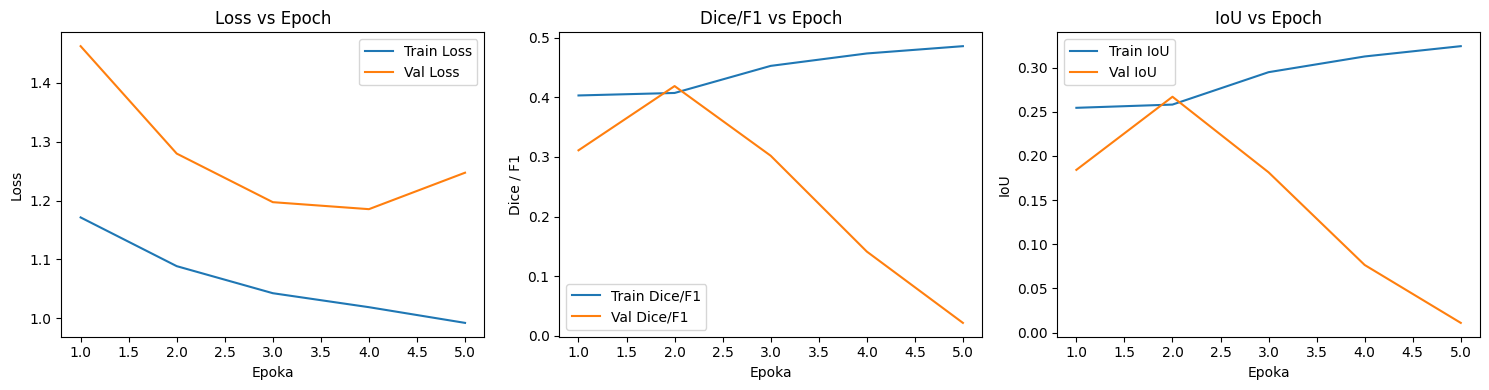

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train size: 800
Val size: 100
Test size: 100


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.4213542640209198     │
│         test_iou          │    0.2681361734867096     │
│         test_loss         │    1.2636511325836182     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.2636511325836182,
  'test_iou': 0.2681361734867096,
  'test_dice': 0.4213542640209198}]

In [ ]:

def metrics_plots(metrics_cb: MetricsCallback):
  metrics = metrics_cb.metrics
  epochs = metrics['epoch']

  plt.figure(figsize=(15, 4))

  plt.subplot(1, 3, 1)
  plt.plot(epochs, metrics['train_loss'][:len(epochs)], label='Train Loss')
  plt.plot(epochs, metrics['val_loss'][:len(epochs)], label='Val Loss')
  plt.xlabel('Epoka')
  plt.ylabel('Loss')
  plt.title('Loss vs Epoch')
  plt.legend()

  plt.subplot(1, 3, 2)
  plt.plot(epochs, metrics['train_dice'][:len(epochs)], label='Train Dice/F1')
  plt.plot(epochs, metrics['val_dice'][:len(epochs)], label='Val Dice/F1')
  plt.xlabel('Epoka')
  plt.ylabel('Dice / F1')
  plt.title('Dice/F1 vs Epoch')
  plt.legend()

  plt.subplot(1, 3, 3)
  plt.plot(epochs, metrics['train_iou'][:len(epochs)], label='Train IoU')
  plt.plot(epochs, metrics['val_iou'][:len(epochs)], label='Val IoU')
  plt.xlabel('Epoka')
  plt.ylabel('IoU')
  plt.title('IoU vs Epoch')
  plt.legend()

  plt.tight_layout()
  plt.show()

metrics_plots(metrics_cb)

best_model1 = LitUnet.load_from_checkpoint(checkpoint.best_model_path)

trainer.test(best_model1, datamodule=dm)


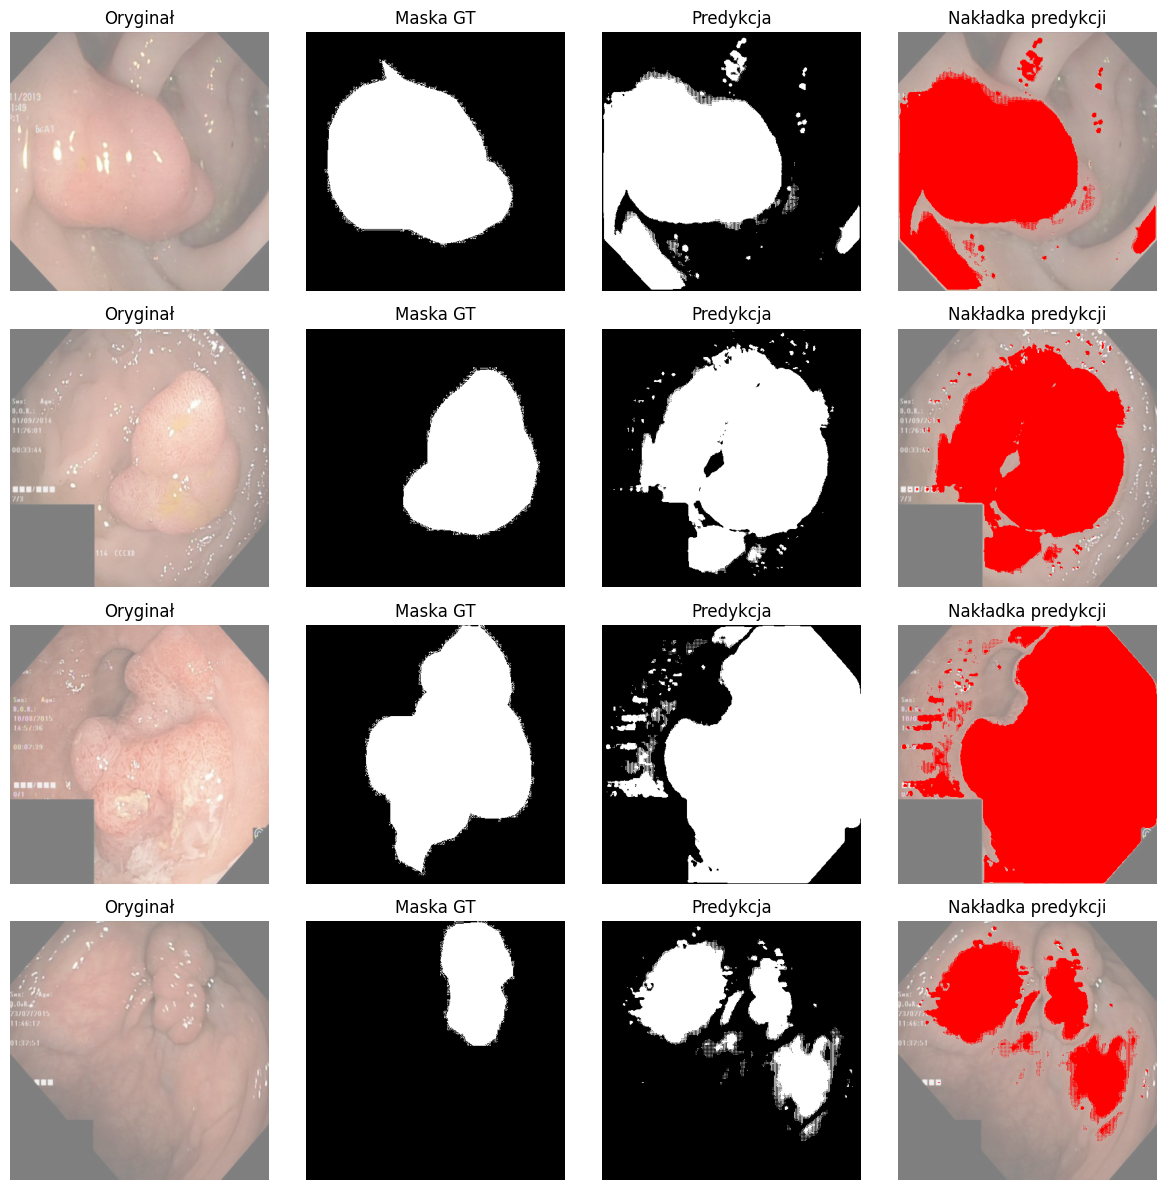

In [ ]:
def visualize_predictions(best_model, dm, num_examples=4):
  best_model.eval()

  xb, yb = next(iter(dm.test_dataloader()))

  with torch.no_grad():
      preds = torch.sigmoid(best_model(xb))
      preds = (preds > 0.5).float()

  plt.figure(figsize=(12, num_examples * 3))

  for i in range(num_examples):
      img = ((xb[i].permute(1, 2, 0).numpy() * 0.5) + 0.5).clip(0, 1)
      mask_gt = yb[i, 0].numpy()
      mask_pred = preds[i, 0].numpy()
      overlay = img.copy()
      overlay[mask_pred > 0.5] = [1.0, 0.0, 0.0]

      plt.subplot(num_examples, 4, i * 4 + 1)
      plt.imshow(img)
      plt.title('Oryginał')
      plt.axis('off')

      plt.subplot(num_examples, 4, i * 4 + 2)
      plt.imshow(mask_gt, cmap='gray')
      plt.title('Maska GT')
      plt.axis('off')

      plt.subplot(num_examples, 4, i * 4 + 3)
      plt.imshow(mask_pred, cmap='gray')
      plt.title('Predykcja')
      plt.axis('off')

      plt.subplot(num_examples, 4, i * 4 + 4)
      plt.imshow(overlay)
      plt.title('Nakładka predykcji')
      plt.axis('off')

  plt.tight_layout()
  plt.show()

visualize_predictions(best_model1, dm, num_examples=4)

## Zadanie 4 – Transfer Learning: U-Net z pre-trained ResNet Encoder

Znowu wykorzystamy transfer learning do zbudowania sieci o większej skuteczności. Zamiast używać całej nauczonej wcześniej sieci wyciągniemy tylko kilka warstw i użyjemy ich w enkoderze modelu U-Net.

1. **ResNetEncoder:**
   - Zaimplementuj klasę `ResNetEncoder`, która dziedziczy po `nn.Module`.
   - W `__init__` przyjmij: `pretrained=True` (czy ładować pretrenowane wagi), `freeze_encoder=False` (czy wczytane wagi mają być zamrożone).
   - Wczytaj pretrained ResNet18: `models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)`.
   - Wyciągnij warstwy enkodera:
     - `resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool` – początkowe warstwy.
     - `resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4` – bloki ResNet (64, 128, 256, 512 kanałów).
   - Jeśli `freeze_encoder=True`, ustaw wszystkie parametry na `requires_grad=False` wewnątrz bloku `for param in self.parameters():`
   - W metodzie `forward(x)` przepuść dane przez warstwy i zwróć 5 tensorów skip connections: `x1` (po conv1), `x2` (po layer1), `x3` (po layer2), `x4` (po layer3), `x5` (po layer4/bottleneck).

2. **UNetResNet:**
   - Zaimplementuj klasę `UNetResNet`, która dziedziczy po `nn.Module`.
   - W `__init__` przyjmij: `pretrained=True`, `freeze_encoder=False`, `dropout`.
   - Stwórz encoder: `self.encoder = ResNetEncoder(pretrained, freeze_encoder)`.
   - Zbuduj decoder (podobnie jak w poprzednim zadaniu):
     - `ConvTranspose2d` upsampling z bottleneck (u1).
     - `DoubleConv` pamiętaj o konkatenacji wyjścia z u1 i skip connection z x4.
     - `ConvTranspose2d` (u2).
     - `DoubleConv` u2 + x3.
     - `ConvTranspose2d` (u3).
     - `DoubleConv` u3 + x2.
     - `ConvTranspose2d` (u4).
     - `DoubleConv` u4 + x1.
     - `ConvTranspose2d` powrót do orygionalej rozdzielczości.
     - `DoubleConv`.
   - Warstwa wyjściowa `Conv2d` z jednym kanałem wyjściowym o rozmiarze 1x1.
   - W metodzie `forward(x)`:
     - Wywołaj encoder: `x1, x2, x3, x4, x5 = self.encoder(x)`.
     - Przepuść przez decoder i skip connections.
     - Zwróć logity.

3. **LitUNetResNet:**
   - Zaimplementuj Lightning wrapper analogicznie do `LitUNet`.
   - Dodaj metody pomocnicze:
     - `freeze_encoder()`: zamraża wagi enkodera (tylko decoder będzie trenowany).
     - `unfreeze_encoder()`: odmraża encoder (cała sieć będzie trenowana).

4. **Test architektury:**
   - Stwórz instancję `UNetResNet`.
   - Przepuść losowy tensor przez sieć i sprawdź kształt wyjścia.
   - Wyświetl osobno liczbę wszystkich oraz liczbę uczonych parametrów `sum(p.numel() for p in model_tl.parameters() if p.requires_grad)`

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class ResNetEncoder(nn.Module):
    def __init__(self, pretrained=True, freeze_encoder=False):
        super(ResNetEncoder, self).__init__()

        self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) if pretrained else models.resnet18()

        self.conv1 = self.resnet.conv1
        self.bn1 = self.resnet.bn1
        self.relu = self.resnet.relu
        self.maxpool = self.resnet.maxpool

        self.layer1 = self.resnet.layer1
        self.layer2 = self.resnet.layer2
        self.layer3 = self.resnet.layer3
        self.layer4 = self.resnet.layer4

        if freeze_encoder:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        x1 = self.relu(self.bn1(self.conv1(x)))
        xp = self.maxpool(x1)

        x2 = self.layer1(xp)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)

        return x1, x2, x3, x4, x5


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class UNetResNet(nn.Module):
    def __init__(self, pretrained=True, freeze_encoder=False, dropout=0.0):
        super(UNetResNet, self).__init__()

        # Encoder z pretrenowanego ResNet
        self.encoder = ResNetEncoder(pretrained, freeze_encoder)

        out_ch= 16
        out_ch1 = 32
        out_ch2 = 64
        out_ch3 = 128
        out_ch4 = 256
        out_ch5 = 512

        # Decoder
        self.u1 = nn.ConvTranspose2d(out_ch5, out_ch4, kernel_size=2, stride=2)
        self.c1 = DoubleConv(2 * out_ch4, out_ch4, dropout)

        self.u2 = nn.ConvTranspose2d(out_ch4, out_ch3, kernel_size=2, stride=2)
        self.c2 = DoubleConv(2 * out_ch3, out_ch3, dropout)

        self.u3 = nn.ConvTranspose2d(out_ch3, out_ch2, kernel_size=2, stride=2)
        self.c3 = DoubleConv(2 * out_ch2, out_ch2, dropout)

        self.u4 = nn.ConvTranspose2d(out_ch2, out_ch1, kernel_size=2, stride=2)
        self.c4 = self.c4 = DoubleConv(32 + 64, out_ch1)

        self.u5 = nn.ConvTranspose2d(out_ch1, out_ch, kernel_size=2, stride=2)
        self.c5 = DoubleConv(out_ch, out_ch, dropout)

        # Wyjście
        self.out_conv = nn.Conv2d(out_ch, 1, kernel_size=1)

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.encoder(x)

        x_u1 = self.c1(torch.cat([self.u1(x5), x4], dim=1))
        x_u2 = self.c2(torch.cat([self.u2(x_u1), x3], dim=1))
        x_u3 = self.c3(torch.cat([self.u3(x_u2), x2], dim=1))
        x_u4 = self.c4(torch.cat([self.u4(x_u3), x1], dim=1))
        x_u5 = self.c5(self.u5(x_u4))

        out = self.out_conv(x_u5)

        return out

class LitUNetResNet(pl.LightningModule):
    def __init__(self, in_ch=3, pretrained=True, freeze_encoder=False, dropout=0.0, lr=1e-3):
      super().__init__()
      self.save_hyperparameters()
      self.model = UNetResNet(pretrained, freeze_encoder, dropout)
      self.loss = nn.BCEWithLogitsLoss()
      self.dice = DiceLoss()
      self.iou = BinaryJaccardIndex(threshold=0.5)
      self.f1 = BinaryF1Score(threshold=0.5)

    def forward(self, x):
      return self.model(x)

    def configure_optimizers(self):
      opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
      sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=6)

      return {"optimizer": opt, "lr_scheduler": sch}

    def freeze_encoder(self):
        for param in self.model.encoder.parameters():
            param.requires_grad = False

    def unfreeze_encoder(self):
        for param in self.model.encoder.parameters():
            param.requires_grad = True

    def _shared_step(self, batch, batch_idx):
      x, y = batch
      out = self(x)
      bce_loss = self.loss(out, y)
      dice_loss = self.dice(out, y)
      total_loss = bce_loss + dice_loss

      with torch.no_grad():
        preds = torch.sigmoid(out) > 0.5
        iou = self.iou(preds.int(), y.int())
        f1 = self.f1(preds.int(), y.int())

      return total_loss, iou, f1

    def training_step(self, batch, batch_idx):
      loss, iou, f1 = self._shared_step(batch, batch_idx)

      self.log('train_loss', loss, on_epoch=True, prog_bar=True)
      self.log('train_iou', iou, on_epoch=True, prog_bar=True)
      self.log('train_dice', f1, on_epoch=True, prog_bar=True)

      return loss

    def validation_step(self, batch, batch_idx):
      loss, iou, f1 = self._shared_step(batch, batch_idx)

      self.log('val_loss', loss, on_epoch=True, prog_bar=True)
      self.log('val_iou', iou, on_epoch=True, prog_bar=True)
      self.log('val_dice', f1, on_epoch=True, prog_bar=True)

      return loss

    def test_step(self, batch, batch_idx):
      loss, iou, f1 = self._shared_step(batch, batch_idx)

      self.log('test_loss', loss, on_epoch=True, prog_bar=True)
      self.log('test_iou', iou, on_epoch=True, prog_bar=True)
      self.log('test_dice', f1, on_epoch=True, prog_bar=True)

      return loss

In [ ]:
unet_resnet_model = UNetResNet(pretrained=False, freeze_encoder=True)

x = torch.randn(1, 3, 224, 224)  # (batch=1, channels=3, H=224, W=224)
y = unet_resnet_model(x)

print(f"Kształt wyjścia: {y.shape}")

total_params = sum(p.numel() for p in unet_resnet_model.parameters())
trainable_params = sum(p.numel() for p in unet_resnet_model.parameters() if p.requires_grad)

print(f"Liczba wszystkich parametrów: {total_params:,}")
print(f"Liczba uczonych parametrów:   {trainable_params:,}")

Kształt wyjścia: torch.Size([1, 1, 224, 224])
Liczba wszystkich parametrów: 14,753,289
Liczba uczonych parametrów:   3,063,777


## Zadanie 5 – Dwuetapowy Transfer Learning: Frozen Encoder

Trening chcemy wykonać podobnie jak w poprzednim ćwiczeniu, czyli zaczynamy od zamrożonych wag z transfer learningu, a potem wykonujemy fine-tuning. Proces treningu jest taki sam jak dla naszej wcześniejszej sieci.

**Trening z zamrożonym encoderem:**
1. Stwórz obiekt klasy `LitUNetResNet` z pretrenowanymi i zamrożonymi wagami.
2. Stwórz callbacki: `MetricsCallback`, `EarlyStopping`, `ModelCheckpoint`.
3. Stwórz `Trainer`.
4. Wywołaj trening sieci wywołując metodę `fit`
5. Wyświetl najlepszy checkpoint i val_dice.
6. Sprawdź oraz wyświetl metryki (3 wykresy: loss, dice, iou) podobnie jak we wcześniejszym treningu.
7. Wczytaj najlepszy model sieci i wykonaj dla niego testy na zbiorze testowym.
8. Wyświetl przykładowe predykcje (4 obrazy × 4 kolumny).

In [ ]:
unet_resnet_model = LitUNetResNet(lr=1e-3, dropout=0.0, pretrained=True, freeze_encoder=True)

unet_resnet_metrics_cb = MetricsCallback()

stop = EarlyStopping(monitor='val_dice', mode='max', patience=4)

unet_resnet_checkpoint = ModelCheckpoint(monitor='val_dice', mode='max',
                             save_top_k=1, filename='frozen-unet-resnet-{epoch:02d}-{val_f1:.3f}')

trainer = Trainer(max_epochs=50, accelerator='auto', devices=1,
                   callbacks=[unet_resnet_metrics_cb, stop, unet_resnet_checkpoint], precision=16)

trainer.fit(unet_resnet_model, dm)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type               | Params | Mode 
-----------------------------------------------------
0 | model | UNetResNet         | 14.8 M | train
1 | loss  | BCEWithLogitsLoss  | 0      | train
2 | dice  | DiceLoss           | 0      | train
3 | iou   | BinaryJaccardIndex | 0      | train
4 | f1    | BinaryF1Score      | 0      | train
-----------------------------------------------------
3.1 M     Trainable params
11.7 M    Non-trainable params
14.8 M    Total params
59.013    Total estimated model params size (MB)
115       Modules in train mode
0         Modules in eval mode


Train size: 800
Val size: 100
Test size: 100


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

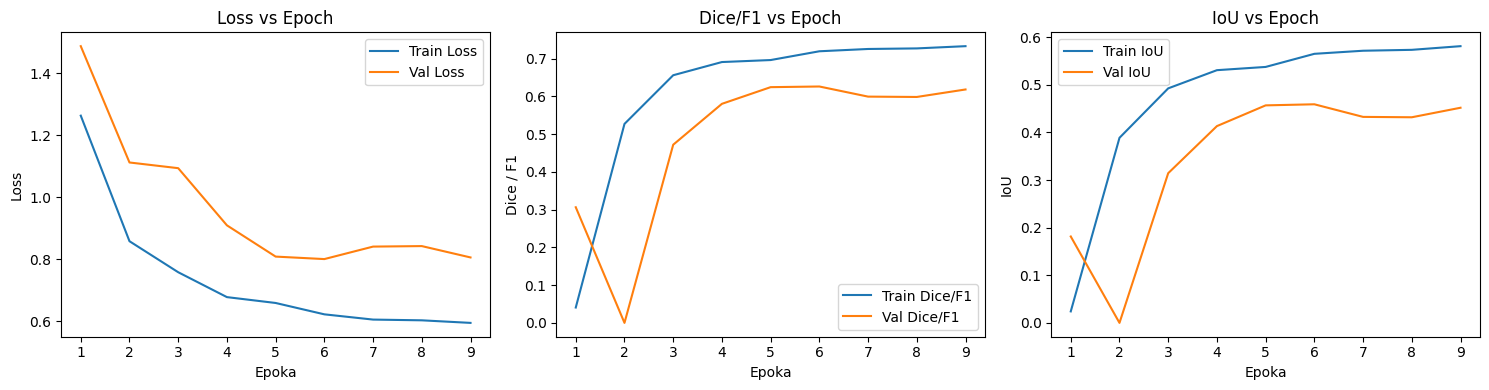

In [ ]:
metrics_plots(unet_resnet_metrics_cb)
best_model2 = LitUNetResNet.load_from_checkpoint(unet_resnet_checkpoint.best_model_path)

In [ ]:
trainer.test(best_model2, datamodule=dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train size: 800
Val size: 100
Test size: 100


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.7124379873275757     │
│         test_iou          │    0.5544188022613525     │
│         test_loss         │    0.6389104127883911     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6389104127883911,
  'test_iou': 0.5544188022613525,
  'test_dice': 0.7124379873275757}]

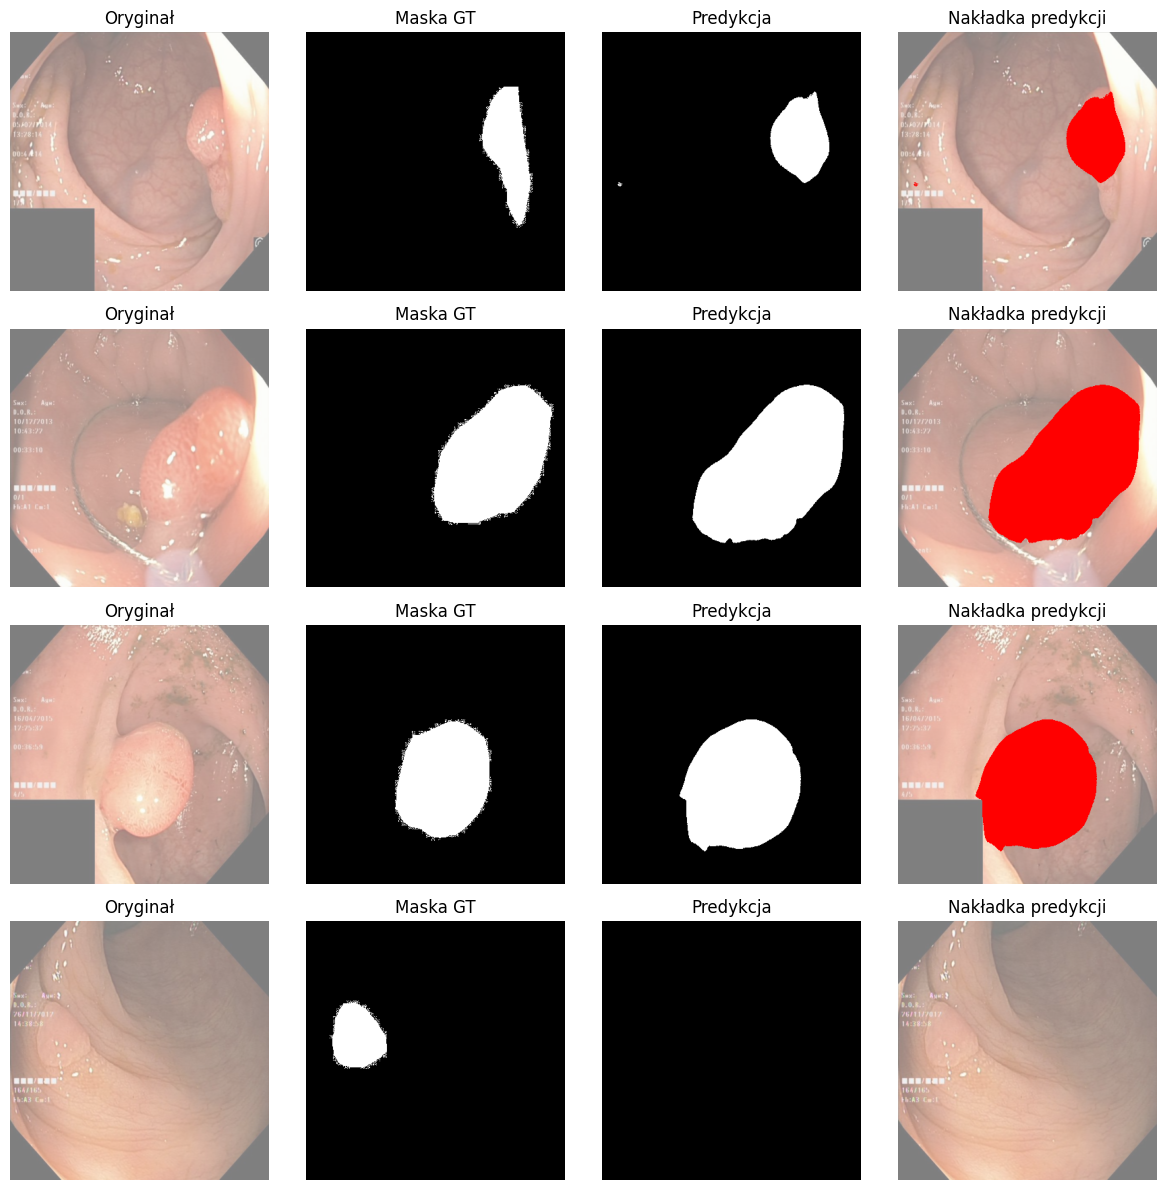

In [ ]:
visualize_predictions(best_model2, dm, num_examples=4)

## Zadanie 6 – Dwuetapowy Transfer Learning: Fine-tuning

**Fine-tuning całej sieci:**
1. Odmroź encoder dla najlepszego modelu z poporzedniej części.
2. Ustaw learning rate: `best_stage1.hparams.lr = ` (podczas fine-tuningu zazwyczaj jest mniejszy).
3. Zaktualizuj hparam: `best_stage1.hparams.freeze_encoder = False`.
4. Stwórz nowe callbacki: `MetricsCallback`, `EarlyStopping`, `ModelCheckpoint`.
5. Stwórz nowy `Trainer`.
6. Wykonaj trening wywołując metodę `fit`.
7. Sprawdź oraz wyświetl metryki (3 wykresy: loss, dice, iou) podobnie jak we wcześniejszym treningu.
8. Wczytaj najlepszy model sieci i wykonaj dla niego testy na zbiorze testowym.
9. Wyświetl przykładowe predykcje (4 obrazy × 4 kolumny).

In [ ]:
best_model2.unfreeze_encoder()
best_model2.hparams.lr = 1e-4
best_model2.hparams.freeze_encoder = False

ft_metrics_cb = MetricsCallback()

stop = EarlyStopping(monitor='val_dice', mode='max', patience=4)

ft_checkpoint = ModelCheckpoint(monitor='val_dice', mode='max',
                             save_top_k=1, filename='frozen-unet-resnet-{epoch:02d}-{val_f1:.3f}')

trainer = Trainer(max_epochs=50, accelerator='auto', devices=1,
                   callbacks=[ft_metrics_cb, stop, ft_checkpoint], precision=16)

trainer.fit(best_model2, dm)


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type               | Params | Mode
----------------------------------------------------
0 | model | UNetResNet         | 14.8 M | eval
1 | loss  | BCEWithLogitsLoss  | 0      | eval
2 | dice  | DiceLoss           | 0      | eval
3 | iou   | BinaryJaccardIndex | 0      | eval
4 | f1    | BinaryF1Score      | 0      | eval
----------------------------------------------------
14.8 M    Trainable params
0         Non-trainable params
14.8 M    Total params
59.013    Total estimated model params size (MB)
0         Modules in train mode
115       Modules in eval mode


Train size: 800
Val size: 100
Test size: 100


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:527: Found 116 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

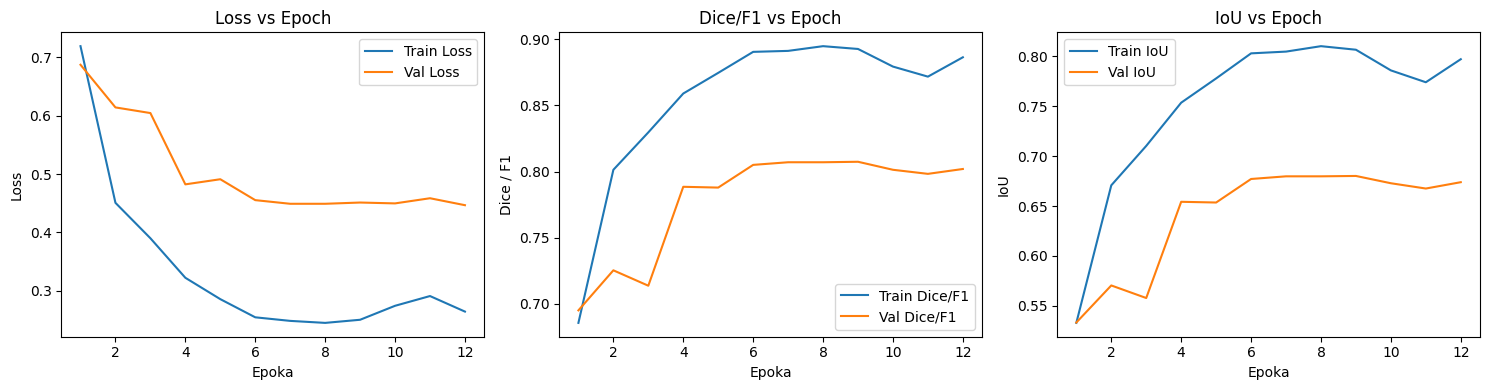

In [ ]:
metrics_plots(ft_metrics_cb)
best_model3 = LitUNetResNet.load_from_checkpoint(ft_checkpoint.best_model_path)

In [ ]:
trainer.test(best_model3, datamodule=dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Train size: 800
Val size: 100
Test size: 100


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_dice         │    0.8536628484725952     │
│         test_iou          │    0.7456479072570801     │
│         test_loss         │    0.3503345847129822     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3503345847129822,
  'test_iou': 0.7456479072570801,
  'test_dice': 0.8536628484725952}]

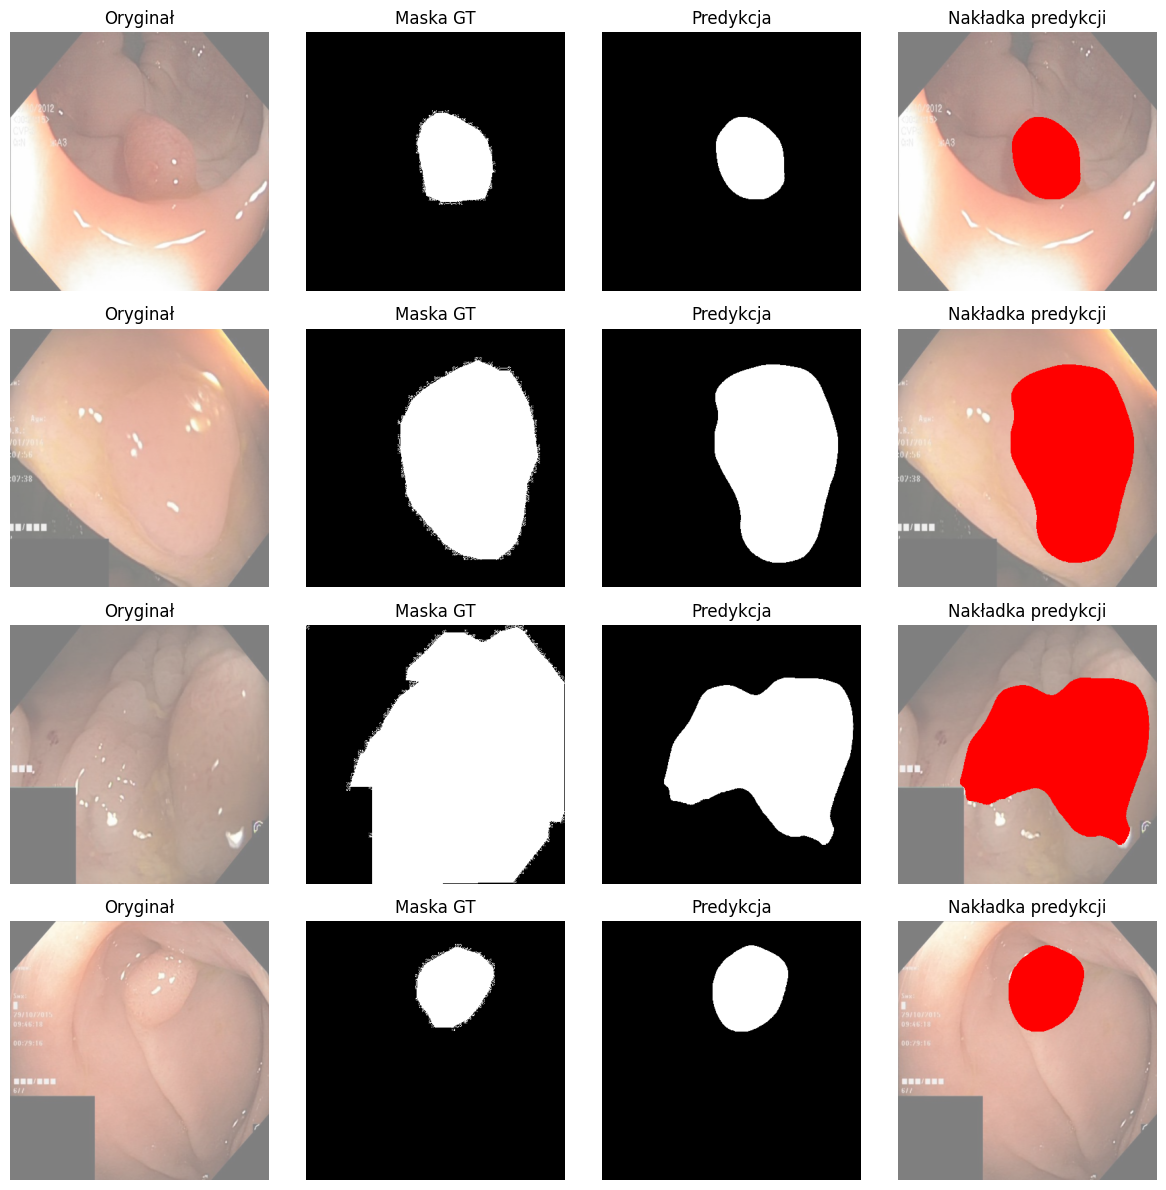

In [ ]:
visualize_predictions(best_model3, dm, num_examples=4)

---

## Podsumowanie i wnioski

Porównaj wyniki przeprowadzonych treningów sieci. Weź pod uwagę liczbę trenowanych parametrów.
Odpowiedz również krótko na poniższe pytania.

1. Czym segmentacja różni się od zadania klasyfikacji?

Klasyfikacja polega na przypisaniu klasy dla całego obrazka, natomiast w segmentacji przypisujemy klasę każdemu pikselowi na obrazie.

2. Czym jest architektura U-Net? Czym ona się charakteryzuje?

Najbardziej charakterystyczną cechą Unet w porównaniu do autoencodera są połączenia skip connections

3. Czym jest funkcja straty DiceLoss?
Pozwala ona na ocenę jakości segmentacji, dzięki obliczaniu straty na podstawie stosunku wspólnej dla predykcji i gt powierzchni na obrazie do całej powierzchni obrazu i maski gt.